<a href="https://colab.research.google.com/github/berachah-beulah/PINN-DeepONet/blob/main/PINN_DeepOnet_current.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
import math
import scipy.stats

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Data.csv to Data (1).csv


In [ ]:
df = pd.read_csv("Data.csv")

X_branch = df[["Porosity", "Permeability", "Thickness", "Salinity", "depth",
               "Residual gas saturation", "Injection rate (ton/day)", "Pressure (kPa)", "Temperature (K)"]].values
X_trunk = df[["Post injection (days)"]].values
y = df[["RTI", "STI"]].values

# Normalize inputs
branch_scaler = MinMaxScaler()
trunk_scaler = MinMaxScaler()
X_branch = branch_scaler.fit_transform(X_branch)
X_trunk = trunk_scaler.fit_transform(X_trunk)

# Train-validation-test split
Xb_train_val, Xb_test, Xt_train_val, Xt_test, y_train_val, y_test = train_test_split(
    X_branch, X_trunk, y, test_size=0.30, random_state=42
)

Xb_train, Xb_val, Xt_train, Xt_val, y_train, y_val = train_test_split(
    Xb_train_val, Xt_train_val, y_train_val, test_size=0.25, random_state=42
)

# Convert to tensors
def to_tensor(arr):
    return torch.tensor(arr, dtype=torch.float32)

train_dataset = TensorDataset(to_tensor(Xb_train), to_tensor(Xt_train), to_tensor(y_train))
val_dataset = TensorDataset(to_tensor(Xb_val), to_tensor(Xt_val), to_tensor(y_val))
test_dataset = TensorDataset(to_tensor(Xb_test), to_tensor(Xt_test), to_tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class FeatureAttention(nn.Module):
    def __init__(self, input_dim, num_groups=1):
        super(FeatureAttention, self).__init__()
        self.attn = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.GroupNorm(num_groups, input_dim),
            nn.SiLU(),
            nn.Linear(input_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        weights = self.attn(x)
        return x * weights

class CrossAttentionFusion(nn.Module):
    def __init__(self, dim, heads=4):
        super(CrossAttentionFusion, self).__init__()
        self.heads = heads
        self.scale = (dim // heads) ** 0.5

        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.out = nn.Linear(dim, dim)
        self.context_proj = nn.Linear(dim // heads, dim)

    def forward(self, b, t):
        B, D = b.size()

        q = self.query(t).view(B, self.heads, -1)
        k = self.key(b).view(B, self.heads, -1)
        v = self.value(b).view(B, self.heads, -1)

        scores = torch.sum(q * k, dim=-1, keepdim=True) / self.scale
        attn = torch.softmax(scores, dim=1)

        context = torch.sum(attn * v, dim=1)
        context = self.context_proj(context)
        return self.out(context + t)

def positional_encoding(t, d_model):
    batch_size = t.size(0)
    pe = torch.zeros(batch_size, d_model, device=t.device)
    position = t
    div_term = torch.exp(torch.arange(0, d_model, 2, device=t.device).float() * (-np.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim):
        super(DeepONet, self).__init__()
        self.attn = FeatureAttention(branch_input_dim)

        def build_dense_block():
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Linear(128, 128)), nn.GroupNorm(4, 128), nn.SiLU()
            )


        num_branch_layers = 2
        num_trunk_layers = 8

        branch_layers = [nn.utils.spectral_norm(nn.Linear(branch_input_dim, 128)), nn.GroupNorm(4, 128), nn.SiLU()]
        for _ in range(num_branch_layers - 1):  # Add remaining layers
            branch_layers.append(build_dense_block())
        self.branch_net = nn.Sequential(*branch_layers)

        trunk_layers = [nn.utils.spectral_norm(nn.Linear(trunk_input_dim, 128)), nn.GroupNorm(4, 128), nn.SiLU()]
        for _ in range(num_trunk_layers - 1):  # Add remaining layers
            trunk_layers.append(build_dense_block())
        self.trunk_net = nn.Sequential(*trunk_layers)

        self.cross_attn = CrossAttentionFusion(128, heads=4)

        self.rti_head = nn.Sequential(
            nn.Linear(128, 64),
            nn.GroupNorm(4, 64),
            nn.SiLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        self.sti_head = nn.Sequential(
            nn.Linear(128, 64),
            nn.GroupNorm(4, 64),
            nn.SiLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, xb, xt):
        xb = self.attn(xb)
        b = self.branch_net(xb)
        pe_xt = positional_encoding(xt, xt.size(-1))
        t = self.trunk_net(xt)
        fused = self.cross_attn(b, t)
        rti = self.rti_head(fused)
        sti = self.sti_head(fused)
        return torch.cat([rti, sti], dim=1)

def gradient_loss(model, xb, xt):
  xt.requires_grad = True
  preds = model(xb, xt)
  grad_outputs = torch.ones_like(preds)
  grads = torch.autograd.grad(
    outputs=preds,
    inputs=xt,
    grad_outputs=grad_outputs,
    create_graph=True,
    retain_graph=True,
    only_inputs=True
  )[0]

  dRTI_dt = grads[:, 0]
  dSTI_dt = grads[:, 0]

  penalty_rti = torch.relu(-dRTI_dt)
  penalty_sti = torch.relu(-dSTI_dt)

  return torch.mean(penalty_rti**2 + penalty_sti**2)

def constraint_penalty(pred):
    """
    Penalty function to enforce the constraint that RTI + STI <= 1
    """
    # Sum of RTI and STI predictions
    total = pred[:, 0] + pred[:, 1]

    # Apply penalty when the sum exceeds 1.0
    penalty = torch.relu(total - 1.0)

    # Return mean squared violation
    return torch.mean(penalty ** 2)

# Helper function to convert numpy arrays to tensors
def to_tensor(x):
    if isinstance(x, torch.Tensor):
        return x
    return torch.tensor(x, dtype=torch.float32)


In [ ]:
# Initialize model
model = DeepONet(branch_input_dim=9, trunk_input_dim=1)
optimizer = torch.optim.AdamW(model.parameters(), lr=9.6e-4, weight_decay=8.5e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=20, factor=0.5)
mse_loss = nn.MSELoss()

patience = 50
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

initial_weight = 0.0
final_weight = 3.0
warmup_epochs = 100
num_epochs = 500

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    physics_weight = 0.0239 #if epoch < warmup_epochs else initial_weight + (final_weight - initial_weight) * ((epoch - warmup_epochs) / (num_epochs - warmup_epochs))
    model.train()
    total_train_loss = 0

    for xb, xt, y_true in train_loader:
        xb, xt, y_true = xb.clone(), xt.clone(), y_true.clone()
        optimizer.zero_grad()

        preds = model(xb, xt)

        loss_data = 0.7 * mse_loss(preds[:, 1:2], y_true[:, 1:2]) + 0.3 * mse_loss(preds[:, 0:1], y_true[:, 0:1])
        loss_phys = 0.0005 #gradient_loss(model, xb, xt)
        loss_const = constraint_penalty(preds)
        loss = loss_data + physics_weight * (loss_phys + loss_const)

        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation loop
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb_val, xt_val, y_val_true in val_loader:
            preds_val = model(xb_val, xt_val)
            loss_val_data = 0.7 * mse_loss(preds_val[:, 1:2], y_val_true[:, 1:2]) + 0.3 * mse_loss(preds_val[:, 0:1], y_val_true[:, 0:1])
            #loss_val_phys = gradient_loss(model, xb_val, xt_val)
            #loss_val_const = constraint_penalty(preds_val)
            loss_val = loss_val_data
            #loss_val = loss_val_data + physics_weight * (loss_val_phys + loss_val_const)
            total_val_loss += loss_val.item()

    avg_val_loss = total_val_loss / len(val_loader)
    scheduler.step(avg_val_loss)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict() # Save the best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            model.load_state_dict(best_model_state) # Load the best model
            break

    if (epoch + 1) % 50 == 0 or epoch == 0:
        pass # Printing handled above

# Evaluation section
def calculate_mae(pred, target):
    return torch.mean(torch.abs(pred - target)).item()

def calculate_violation_rate(pred):
    total = pred[:, 0] + pred[:, 1]
    violations = torch.sum(total > 1)
    return violations.item() / len(pred)

Epoch 1, Train Loss: 0.010081, Val Loss: 0.008656
Epoch 2, Train Loss: 0.007883, Val Loss: 0.008266
Epoch 3, Train Loss: 0.007609, Val Loss: 0.008176
Epoch 4, Train Loss: 0.007575, Val Loss: 0.008070
Epoch 5, Train Loss: 0.007739, Val Loss: 0.007895
Epoch 6, Train Loss: 0.006847, Val Loss: 0.007840
Epoch 7, Train Loss: 0.006011, Val Loss: 0.007459
Epoch 8, Train Loss: 0.005273, Val Loss: 0.007627
Epoch 9, Train Loss: 0.005683, Val Loss: 0.007527
Epoch 10, Train Loss: 0.005413, Val Loss: 0.006309
Epoch 11, Train Loss: 0.004777, Val Loss: 0.006129
Epoch 12, Train Loss: 0.005000, Val Loss: 0.005985
Epoch 13, Train Loss: 0.004645, Val Loss: 0.005712
Epoch 14, Train Loss: 0.004389, Val Loss: 0.006215
Epoch 15, Train Loss: 0.004030, Val Loss: 0.005487
Epoch 16, Train Loss: 0.003553, Val Loss: 0.005608
Epoch 17, Train Loss: 0.003711, Val Loss: 0.005464
Epoch 18, Train Loss: 0.003638, Val Loss: 0.005347
Epoch 19, Train Loss: 0.003738, Val Loss: 0.005120
Epoch 20, Train Loss: 0.003508, Val Loss

In [ ]:
# Evaluation
model.eval()
with torch.no_grad():
    test_preds = model(to_tensor(Xb_test), to_tensor(Xt_test))
    test_pred = test_preds
    y_test_tensor = to_tensor(y_test)

    # Training data
    train_preds = model(to_tensor(Xb_train), to_tensor(Xt_train)).numpy()

    # Test data
    test_preds = model(to_tensor(Xb_test), to_tensor(Xt_test)).numpy()

    # Cross-validation data (using validation set)
    val_preds = model(to_tensor(Xb_val), to_tensor(Xt_val)).numpy()

test_mae = calculate_mae(test_pred, y_test_tensor)
test_mae_rti = calculate_mae(test_pred[:, 0], y_test_tensor[:, 0])
test_mae_sti = calculate_mae(test_pred[:, 1], y_test_tensor[:, 1])

violation_rate = calculate_violation_rate(test_pred)

r2_rti = r2_score(y_test_tensor[:, 0].numpy(), test_pred[:, 0].numpy())
r2_sti = r2_score(y_test_tensor[:, 1].numpy(), test_pred[:, 1].numpy())

y_pred_inv = test_pred.numpy() # Assuming test_pred are your model's predictions
y_true_inv = y_test  # y_test

print("\n=== Final Test Results (using best model from validation) ===")
print(f"Overall MAE: {test_mae:.4f} (RTI: {test_mae_rti:.4f}, STI: {test_mae_sti:.4f})")
print(f"Constraint Violation Rate: {violation_rate:.1%}")
print(f"R2 Scores - RTI: {r2_rti:.3f}, STI: {r2_sti:.3f}")


=== Final Test Results (using best model from validation) ===
Overall MAE: 0.0037 (RTI: 0.0047, STI: 0.0026)
Constraint Violation Rate: 0.0%
R2 Scores - RTI: 0.992, STI: 0.982


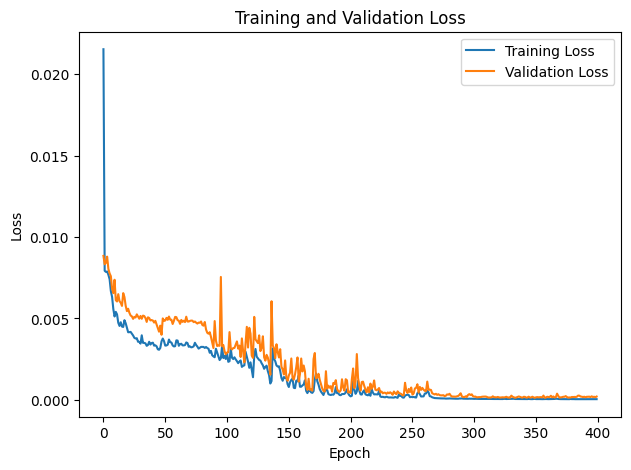

In [ ]:
history = {'train_loss': train_losses, 'val_loss': val_losses}
plt.figure(figsize=(7, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
# Visualization
plt.figure(figsize=(12, 5))
for i, target in enumerate(['RTI', 'STI']):
    plt.subplot(1, 2, i+1)
    plt.scatter(y_true_inv[:, i], y_pred_inv[:, i], alpha=0.6)
    plt.plot([y_true_inv[:, i].min(), y_true_inv[:, i].max()],
             [y_true_inv[:, i].min(), y_true_inv[:, i].max()], 'r--')
    plt.xlabel(f'Actual {target}')
    plt.ylabel(f'Predicted {target}')
    mae = mean_absolute_error(y_true_inv[:, i], y_pred_inv[:, i])
    plt.title(f'{target} Prediction\nMAE: {mae:.4f}')
plt.tight_layout()
plt.savefig('predictions_vs_actual.png')
plt.close()

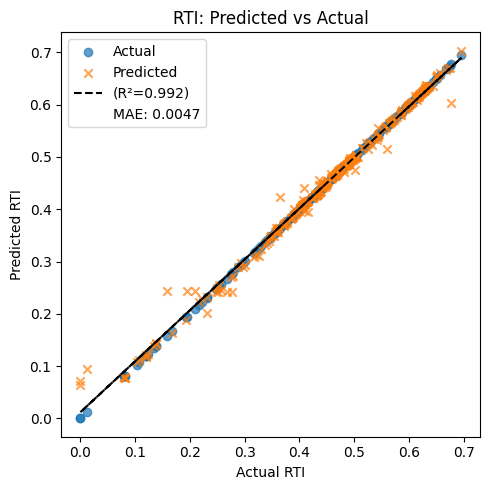

In [ ]:
# Predicted vs Actual scatter plots with regression lines and residual plots
def plot_pred_vs_actual(y_true, y_pred, label):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
    line = slope * y_true + intercept
    mae = mean_absolute_error(y_true, y_pred)  # Calculate MAE

    # Scatter plot for actual values
    plt.scatter(y_true, y_true, alpha=0.7, label='Actual', marker='o')

    # Scatter plot for predicted values
    plt.scatter(y_true, y_pred, alpha=0.7, label='Predicted', marker='x')

    plt.plot(y_true, line, 'k--', label=f'(R²={r_value**2:.3f})')

    plt.xlabel(f"Actual {label}")
    plt.ylabel(f"Predicted {label}")  # Updated y-axis label
    plt.title(f"{label}: Predicted vs Actual")

    # Add MAE to legend
    handles, labels = plt.gca().get_legend_handles_labels()
    labels.append(f"MAE: {mae:.4f}")  # Add MAE to labels
    handles.append(plt.Rectangle((0, 0), 1, 1, fc="white", ec="white")) # create a dummy handle
    plt.legend(handles, labels, loc='best') # Use updated handles and labels

# RTI plotting code
plt.figure(figsize=(5, 5))
plot_pred_vs_actual(y_true_inv[:, 0], y_pred_inv[:, 0], "RTI")
plt.tight_layout()
plt.show()

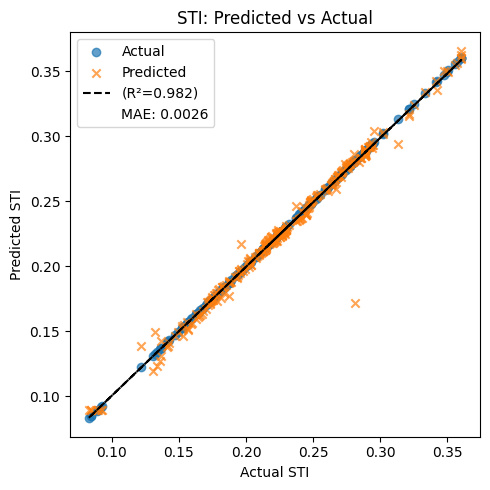

In [ ]:
def plot_pred_vs_actual(y_true, y_pred, label):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
    line = slope * y_true + intercept
    mae = mean_absolute_error(y_true, y_pred)  # Calculate MAE

    # Scatter plot for actual values
    plt.scatter(y_true, y_true, alpha=0.7, label='Actual', marker='o')

    # Scatter plot for predicted values
    plt.scatter(y_true, y_pred, alpha=0.7, label='Predicted', marker='x')

    plt.plot(y_true, line, 'k--', label=f'(R²={r_value**2:.3f})')

    plt.xlabel(f"Actual {label}")
    plt.ylabel(f"Predicted {label}")  # Updated y-axis label
    plt.title(f"{label}: Predicted vs Actual")

    # Add MAE to legend
    handles, labels = plt.gca().get_legend_handles_labels()
    labels.append(f"MAE: {mae:.4f}")  # Add MAE to labels
    handles.append(plt.Rectangle((0, 0), 1, 1, fc="white", ec="white")) # create a dummy handle
    plt.legend(handles, labels, loc='best') # Use updated handles and labels

plt.figure(figsize=(5, 5))
plot_pred_vs_actual(y_true_inv[:, 1], y_pred_inv[:, 1], "STI")
plt.tight_layout()
plt.show()

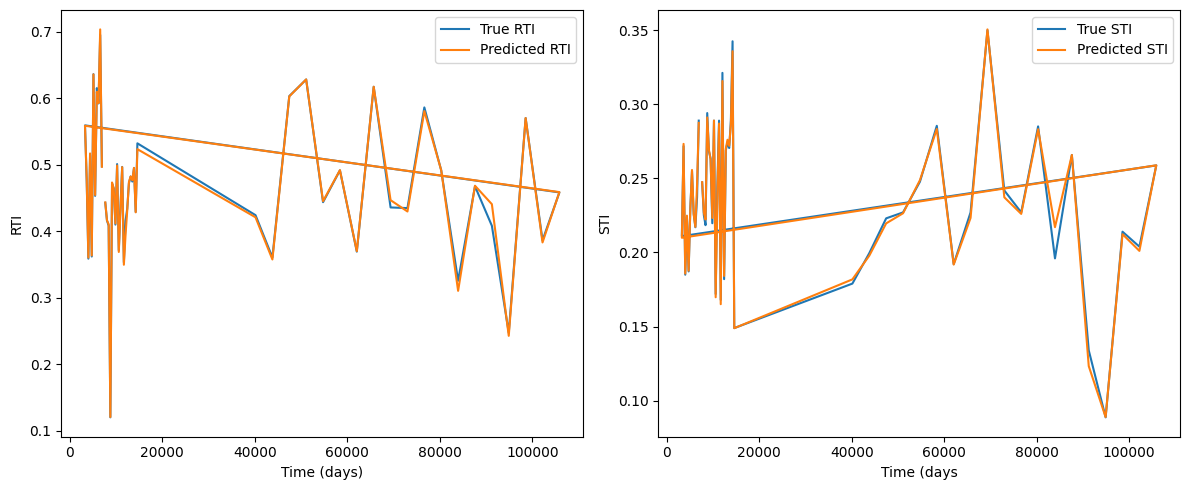

In [ ]:
# Plot RTI and STI vs Time for a sample
# sample_indices = X_trunk[:, 0].argsort()[:100]  # This line is causing the issue

# Instead, get sample indices from y_true_inv or y_pred_inv
sample_indices = np.arange(len(y_true_inv))[:50]  # Take the first 100 samples

time_vals = df.iloc[sample_indices]["Post injection (days)"].values

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(time_vals, y_true_inv[sample_indices, 0], label="True RTI")
plt.plot(time_vals, y_pred_inv[sample_indices, 0], label="Predicted RTI")
plt.xlabel("Time (days)")
plt.ylabel("RTI")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time_vals, y_true_inv[sample_indices, 1], label="True STI")
plt.plot(time_vals, y_pred_inv[sample_indices, 1], label="Predicted STI")
plt.xlabel("Time (days")
plt.ylabel("STI")
plt.legend()

plt.tight_layout()
plt.show()

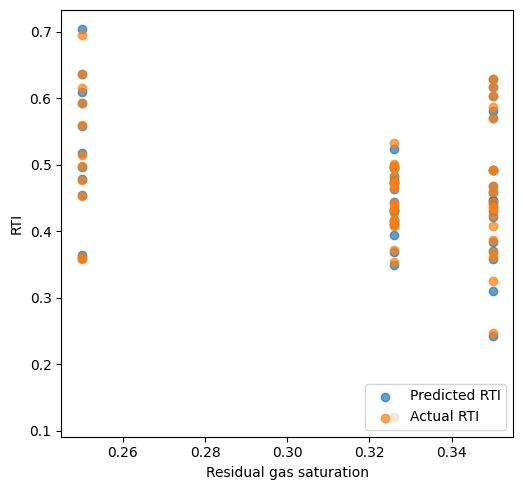

In [ ]:
# Additional visualizations based on porosity and injection rate
saturation_vals = df.iloc[sample_indices]["Residual gas saturation"].values

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(saturation_vals, y_pred_inv[sample_indices, 0], label="Predicted RTI", alpha=0.7)
plt.scatter(saturation_vals, y_true_inv[sample_indices, 0], label="Actual RTI", alpha=0.7)
plt.xlabel("Residual gas saturation")
plt.ylabel("RTI")
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

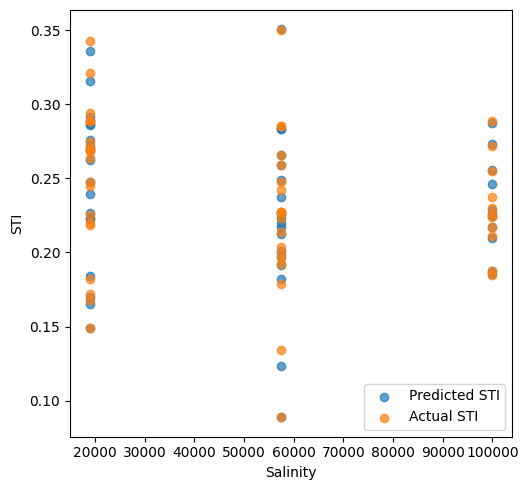

In [ ]:
# Additional visualizations based on porosity and injection rate
salinity_vals = df.iloc[sample_indices]["Salinity"].values

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.scatter(salinity_vals, y_pred_inv[sample_indices, 1], label="Predicted STI", alpha=0.7)
plt.scatter(salinity_vals, y_true_inv[sample_indices, 1], label="Actual STI", alpha=0.7)
plt.xlabel("Salinity")
plt.ylabel("STI")
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

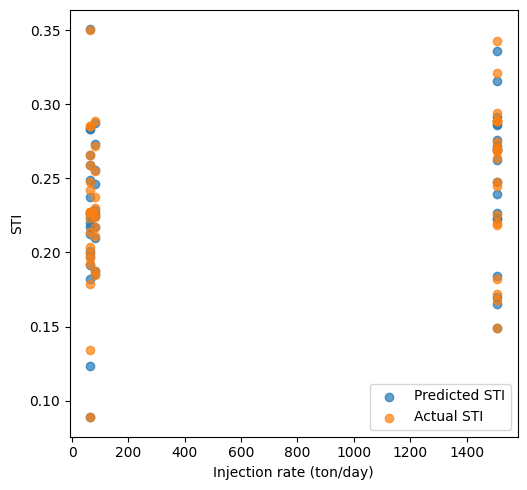

In [ ]:
injection_vals = df.iloc[sample_indices]["Injection rate (ton/day)"].values

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.scatter(injection_vals, y_pred_inv[sample_indices, 1], label="Predicted STI", alpha=0.7)
plt.scatter(injection_vals, y_true_inv[sample_indices, 1], label="Actual STI", alpha=0.7)
plt.xlabel("Injection rate (ton/day)")
plt.ylabel("STI")
plt.legend()

plt.tight_layout()
plt.show()

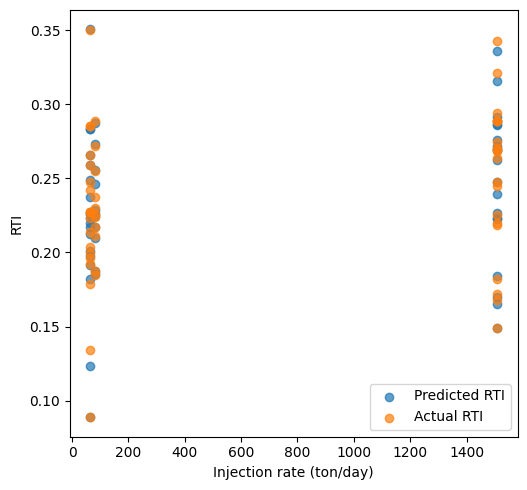

In [ ]:
injection_vals = df.iloc[sample_indices]["Injection rate (ton/day)"].values

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.scatter(injection_vals, y_pred_inv[sample_indices, 1], label="Predicted RTI", alpha=0.7)
plt.scatter(injection_vals, y_true_inv[sample_indices, 1], label="Actual RTI", alpha=0.7)
plt.xlabel("Injection rate (ton/day)")
plt.ylabel("RTI")
plt.legend()

plt.tight_layout()
plt.show()

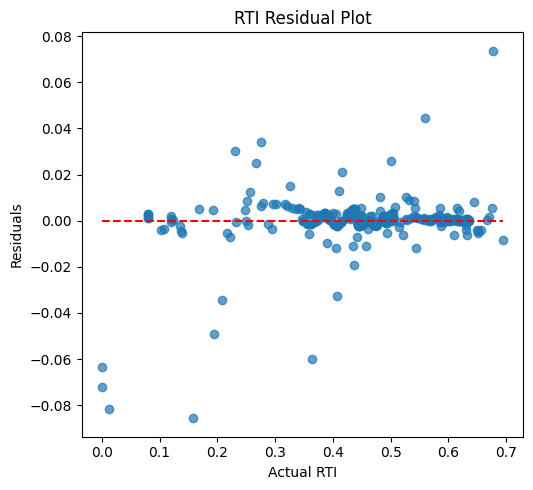

In [ ]:
plt.figure(figsize=(10, 5))

# Residual plot for RTI
plt.subplot(1, 2, 1)
residuals_rti = y_true_inv[:, 0] - y_pred_inv[:, 0]
plt.scatter(y_true_inv[:, 0], residuals_rti, alpha=0.7)
plt.hlines(y=0, xmin=y_true_inv[:, 0].min(), xmax=y_true_inv[:, 0].max(), linestyles='dashed', colors='red')
plt.xlabel("Actual RTI")
plt.ylabel("Residuals")
plt.title("RTI Residual Plot")

plt.tight_layout()
plt.show()

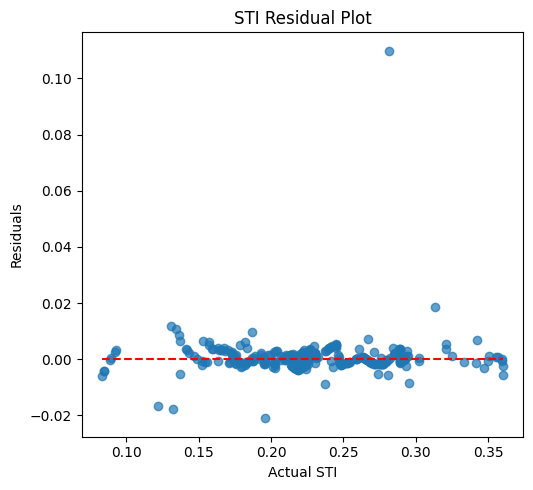

In [ ]:
plt.figure(figsize=(10, 5))

# Residual plot for STI
plt.subplot(1, 2, 2)
residuals_sti = y_true_inv[:, 1] - y_pred_inv[:, 1]
plt.scatter(y_true_inv[:, 1], residuals_sti, alpha=0.7)
plt.hlines(y=0, xmin=y_true_inv[:, 1].min(), xmax=y_true_inv[:, 1].max(), linestyles='dashed', colors='red')
plt.xlabel("Actual STI")
plt.ylabel("Residuals")
plt.title("STI Residual Plot")

plt.tight_layout()
plt.show()

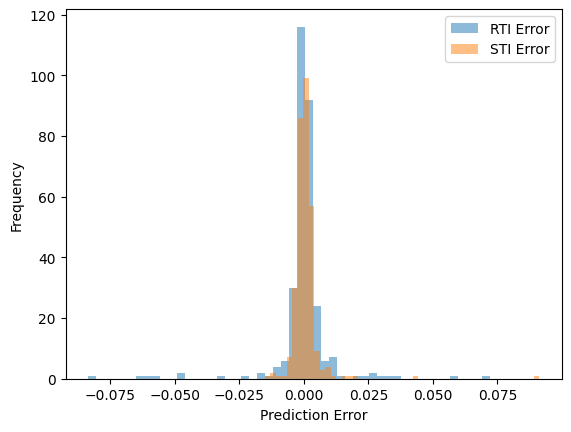

In [ ]:
error_rti = y_true_inv[:, 0] - y_pred_inv[:, 0]
error_sti = y_true_inv[:, 1] - y_pred_inv[:, 1]

plt.hist(error_rti, bins=50, alpha=0.5, label="RTI Error")
plt.hist(error_sti, bins=50, alpha=0.5, label="STI Error")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

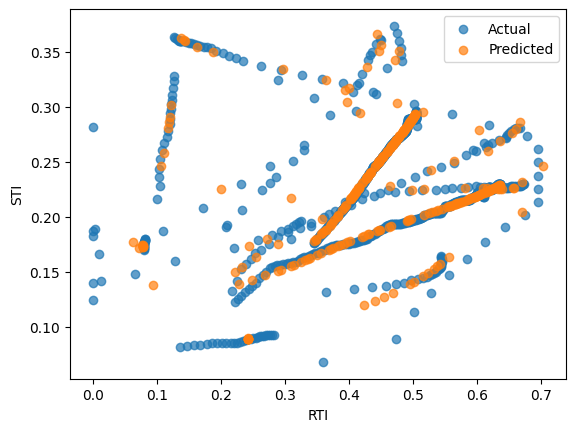

In [ ]:
plt.scatter(df["RTI"], df["STI"], label="Actual", alpha=0.7)
plt.scatter(y_pred_inv[:, 0], y_pred_inv[:, 1], label="Predicted", alpha=0.7)
plt.xlabel("RTI")
plt.ylabel("STI")
plt.legend()
plt.show()